# MLP Model

Goal: Create a multilayer perceptron model (MLP) and train it on our final data set. This first model is a vanilla neural network (NN) that will be used as a baseline for comparing the performance of other NN models on future iterations.

In the next iteration I plan to compare the performance of my current model to a model with additional feature engineering. Specifically, I plan on applying a gaussian distribution to the vol_20 feature which I used as a measure of implied volatility. The distribution will use underlying securities data to assign a degree of confidene (or a probability distribution) to various possible values of vol_20. These various possible values of vol_20 will be weighted and used as features to the NN as oppossed to a single vol_20 input.

Future iterations will primarily include hyper-paramater tuning and cross-validation techniques in order to maximize the efficacy of the multilayer perceptron model. In addition, I may test the performance of LSTM models against my tuned MLP model as they are commonly used for options pricing. 



In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, LeakyReLU, BatchNormalization
from tensorflow.keras import backend
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

In [119]:
from scipy.stats import norm

In [3]:
%cd '/Users/benjochem/Desktop/Junior/Deep Learning Research/Project/data/interim'

/Users/benjochem/Desktop/Junior/Deep Learning Research/Project/data/interim


In [4]:
features = pd.read_csv('features.csv')
features[40:65]

,Date,exDate,cp_flag,TTE,strike_price,treasury_rate,sec_price,option_volume,open_interest,sec_volume,sec_return,vol_20,best_bid,best_offer
40,20100528,20100619,P,22,26000,0.15,28.58,1388,0,33996602,0.008825,0.072646,0.90,1.00
41,20100528,20100619,P,22,27000,0.15,28.58,1177,0,33996602,0.008825,0.072646,1.35,1.45
42,20100528,20100619,P,22,28000,0.15,28.58,1171,0,33996602,0.008825,0.072646,1.90,2.10
43,20100528,20100619,P,22,29000,0.15,28.58,970,0,33996602,0.008825,0.072646,2.40,2.70
44,20100528,20100619,P,22,30000,0.15,28.58,741,0,33996602,0.008825,0.072646,3.20,3.50
45,20100528,20100619,P,22,31000,0.15,28.58,100,0,33996602,0.008825,0.072646,3.90,4.20
46,20100528,20100619,P,22,32000,0.15,28.58,100,0,33996602,0.008825,0.072646,4.70,5.00
47,20100528,20100619,P,22,33000,0.15,28.58,101,0,33996602,0.008825,0.072646,5.50,5.90
48,20100528,20100619,P,22,34000,0.15,28.58,60,0,33996602,0.008825,0.072646,6.30,6.70
49,20100528,20100619,P,22,35000,0.15,28.58,60,0,33996602,0.008825,0.072646,7.20,7.60


In [5]:
# call / put options will be trained separately. Check # observations for each
features['cp_flag'].value_counts()

C    1560604
P    1560525
Name: cp_flag, dtype: int64

In [6]:
features.isnull().sum()

Date               0
exDate             0
cp_flag            0
TTE                0
strike_price       0
treasury_rate    356
sec_price          0
option_volume      0
open_interest      0
sec_volume         0
sec_return         0
vol_20             0
best_bid           0
best_offer         0
dtype: int64

In [7]:
#drop all options data with missing values
features = features.dropna(axis=0)
print(len(features))

3120773


In [8]:
features = features[['cp_flag','TTE','strike_price','treasury_rate','sec_price','vol_20','best_bid','best_offer']]
features.head()

,cp_flag,TTE,strike_price,treasury_rate,sec_price,vol_20,best_bid,best_offer
0,C,22,15000,0.15,28.58,0.072646,13.3,13.8
1,C,22,16000,0.15,28.58,0.072646,12.3,12.8
2,C,22,17000,0.15,28.58,0.072646,11.3,11.8
3,C,22,18000,0.15,28.58,0.072646,10.3,10.8
4,C,22,19000,0.15,28.58,0.072646,9.3,9.8


In [9]:
features.strike_price = features.strike_price /1000
features.head()

,cp_flag,TTE,strike_price,treasury_rate,sec_price,vol_20,best_bid,best_offer
0,C,22,15.0,0.15,28.58,0.072646,13.3,13.8
1,C,22,16.0,0.15,28.58,0.072646,12.3,12.8
2,C,22,17.0,0.15,28.58,0.072646,11.3,11.8
3,C,22,18.0,0.15,28.58,0.072646,10.3,10.8
4,C,22,19.0,0.15,28.58,0.072646,9.3,9.8


In [141]:
features[55:60]

,cp_flag,TTE,strike_price,treasury_rate,sec_price,vol_20,best_bid,best_offer
55,P,22,41.0,0.15,28.58,0.072646,12.7,13.0
56,P,22,42.0,0.15,28.58,0.072646,13.6,14.0
57,P,22,43.0,0.15,28.58,0.072646,14.6,14.9
58,C,50,15.0,0.16,28.58,0.072646,12.7,14.3
59,C,50,16.0,0.16,28.58,0.072646,11.7,13.3


In [10]:
# seperate call and put options
calls = features[features['cp_flag']=='C'].drop(['cp_flag'], axis=1)
puts = features[features['cp_flag']=='P'].drop(['cp_flag'], axis=1)
calls.head()

,TTE,strike_price,treasury_rate,sec_price,vol_20,best_bid,best_offer
0,22,15.0,0.15,28.58,0.072646,13.3,13.8
1,22,16.0,0.15,28.58,0.072646,12.3,12.8
2,22,17.0,0.15,28.58,0.072646,11.3,11.8
3,22,18.0,0.15,28.58,0.072646,10.3,10.8
4,22,19.0,0.15,28.58,0.072646,9.3,9.8


In [11]:
# split the call and put datasets into train and test sets
# will use simple validation set of 1% of training data
# k-fold cross validation may later be used
call_x_train, call_x_test, call_y_train, call_y_test = train_test_split(calls.drop(['best_bid', 'best_offer'], axis=1),
                                                                        calls[['best_bid', 'best_offer']],
                                                                        test_size=0.01, random_state=23)
put_x_train, put_x_test, put_y_train, put_y_test = train_test_split(puts.drop(['best_bid', 'best_offer'], axis=1),
                                                                    puts[['best_bid', 'best_offer']],
                                                                    test_size=0.01, random_state=23)

In [665]:
#create first multi-layer perceptron model
mod = Sequential()

# add first fully-connected layer
mod.add(Dense(400, input_dim = 5))  # fully connected, 400 nodes, 5 input features
mod.add(LeakyReLU()) #Use leaky Relu activation function

# middle layers
for _ in range(3):
    mod.add(Dense(400))
    mod.add(BatchNormalization())
    mod.add(LeakyReLU())

#output layer
mod.add(Dense(2, activation='relu'))

mod.compile(loss='mse', optimizer=Adam()) # mse as loss function b/c options pricing is a regression task

In [666]:
mod.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 400)               2400      
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 400)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 400)               160400    
_________________________________________________________________
batch_normalization_21 (Batc (None, 400)               1600      
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 400)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 400)               160400    
_________________________________________________________________
batch_normalization_22 (Batc (None, 400)              

In [ ]:
# fit the model
history = mod.fit(call_x_train, call_y_train, 
                    batch_size = 1024, epochs = 350, 
                    validation_split = 0.01,
                    callbacks=[TensorBoard(histogram_freq = 10, update_freq = 'epoch', write_graph = True)],
                    verbose=1)

In [ ]:
#save the model and history
mod.save('mod_350e')
mod_250e_history = history.history
np.save('350e_history.npy', mod_250e_history)

In [18]:
history80 = np.load('80e_history.npy', allow_pickle=True)
history140 = np.load('140e_history.npy', allow_pickle=True)
history250 = np.load('250e_history.npy', allow_pickle=True)
history350 = np.load('350e_history.npy', allow_pickle=True)

In [33]:
history80 = dict(enumerate(history80.flatten(), 1))[1]
history140 = dict(enumerate(history140.flatten(), 1))[1]
history250 = dict(enumerate(history250.flatten(), 1))[1]
history350 = dict(enumerate(history350.flatten(), 1))[1]

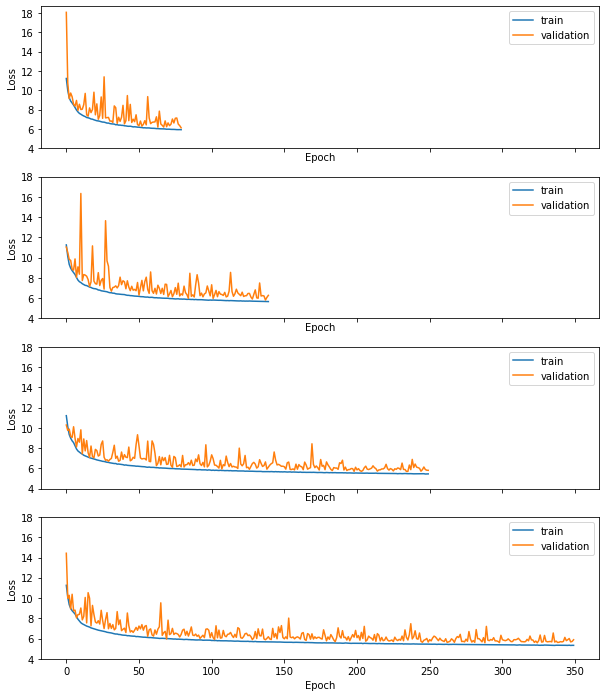

In [89]:
# Plot of model loss across train and test(validation) sets by epoch
fig, [ax1,ax2,ax3,ax4] = plt.subplots(4, sharex=True, figsize = (10,12))
ax1.plot(history80['loss'])
ax1.plot(history80['val_loss'])
ax2.plot(history140['loss'])
ax2.plot(history140['val_loss'])
ax3.plot(history250['loss'])
ax3.plot(history250['val_loss'])
ax4.plot(history350['loss'])
ax4.plot(history350['val_loss'])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Loss')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Loss')
ax1.legend(['train', 'validation'], loc='upper right')
ax2.legend(['train', 'validation'], loc='upper right')
ax3.legend(['train', 'validation'], loc='upper right')
ax4.legend(['train', 'validation'], loc='upper right')
ax1.set_yticks([4,6,8,10,12,14,16,18])
ax2.set_yticks([4,6,8,10,12,14,16,18])
ax3.set_yticks([4,6,8,10,12,14,16,18])
ax4.set_yticks([4,6,8,10,12,14,16,18])


In [91]:
model80 = load_model('mod_80e')
model140 = load_model('mod_140e')
model250 = load_model('mod_250e')
model350 = load_model('mod_350e')

In [94]:
#evaluate the model on the test set that was not used in training to find loss (mse)
results80 = model80.evaluate(call_x_test,call_y_test)
print(model80.metrics_names)
print(results80)

488/488 [==============================] - 0s 611us/step - loss: 5.4347
['loss']
5.434683799743652


In [95]:
results140 = model140.evaluate(call_x_test,call_y_test)
print(model140.metrics_names)
print(results140)

488/488 [==============================] - 0s 610us/step - loss: 5.8361
['loss']
5.836131572723389


In [96]:
results250 = model250.evaluate(call_x_test,call_y_test)
print(model250.metrics_names)
print(results250)

488/488 [==============================] - 0s 609us/step - loss: 5.1891
['loss']
5.189092636108398


In [97]:
results350 = model350.evaluate(call_x_test,call_y_test)
print(model350.metrics_names)
print(results350)

488/488 [==============================] - 0s 606us/step - loss: 5.2478
['loss']
5.247835159301758


In [99]:
call_x_test

,TTE,strike_price,treasury_rate,sec_price,vol_20
73791,380,36.0,0.30,35.930,0.016490
1590816,220,42.0,0.41,16.160,0.043622
2250210,361,25.0,1.79,26.250,0.019597
524236,303,65.0,0.14,21.020,0.044703
1058823,80,33.0,0.03,31.019,0.063393
...,...,...,...,...,...
2995835,11,54.0,2.04,24.480,0.057684
2026072,506,64.0,1.23,47.650,0.678849
2946485,148,18.0,2.08,22.200,0.022500
1233758,31,25.5,0.01,21.470,0.026204


In [104]:
# use model to predict the labels of our call_x_test set. Will compare to actual labels 
call80_y_predictions = model80.predict(call_x_test)
call80_y_predictions=pd.DataFrame(call80_y_predictions)

#model's predicted bid and ask prices
call80_y_predictions=call80_y_predictions.rename(columns={0:"best_bid",1:"best_offer"})
call80_y_predictions

,best_bid,best_offer
0,6.529744,6.943429
1,0.982468,1.041291
2,4.262253,4.586849
3,0.717854,0.917998
4,2.685948,2.919593
...,...,...
15600,0.000000,0.000000
15601,9.632830,10.584862
15602,5.332734,5.419815
15603,0.785175,0.813294


In [110]:
# use model to predict the labels of our call_x_test set. Will compare to actual labels 
call140_y_predictions = model140.predict(call_x_test)
call140_y_predictions=pd.DataFrame(call140_y_predictions)

#model's predicted bid and ask prices
call140_y_predictions=call140_y_predictions.rename(columns={0:"best_bid",1:"best_offer"})
call140_y_predictions

,best_bid,best_offer
0,5.940762,6.658382
1,0.454244,0.550227
2,4.416494,5.044466
3,0.505748,0.652340
4,2.707041,2.964024
...,...,...
15600,0.000000,0.000000
15601,9.831182,10.400362
15602,5.644578,5.742529
15603,0.276759,0.352164


In [108]:
# use model to predict the labels of our call_x_test set. Will compare to actual labels 
call250_y_predictions = model250.predict(call_x_test)
call250_y_predictions=pd.DataFrame(call250_y_predictions)

#model's predicted bid and ask prices
call250_y_predictions=call250_y_predictions.rename(columns={0:"best_bid",1:"best_offer"})
call250_y_predictions

,best_bid,best_offer
0,7.135064,7.546931
1,0.758298,0.846153
2,4.533821,5.107157
3,0.169438,0.377669
4,2.954770,3.172551
...,...,...
15600,0.000000,0.000000
15601,10.413900,11.503784
15602,5.248538,5.372693
15603,0.650443,0.639279


In [113]:
# use model to predict the labels of our call_x_test set. Will compare to actual labels 
call350_y_predictions = model350.predict(call_x_test)
call350_y_predictions=pd.DataFrame(call350_y_predictions)

#model's predicted bid and ask prices
call350_y_predictions=call350_y_predictions.rename(columns={0:"best_bid",1:"best_offer"})
call350_y_predictions

,best_bid,best_offer
0,5.931215,6.254350
1,0.517722,0.527568
2,4.187885,4.270200
3,0.201636,0.481986
4,2.080117,2.396988
...,...,...
15600,0.000000,0.000000
15601,9.596577,11.158598
15602,5.546924,5.381753
15603,0.122376,0.181517


In [105]:
#actual bid and ask prices
cally_test = call_y_test.reset_index()
cally_test = cally_test[['best_bid', 'best_offer']]
cally_test

,best_bid,best_offer
0,0.00,0.44
1,0.77,0.81
2,0.22,0.48
3,0.00,0.02
4,3.30,3.45
...,...,...
15600,0.00,0.01
15601,11.65,12.55
15602,5.60,5.75
15603,0.50,0.54


In [188]:
# create a plot of test set % error. Plot ask % error against ask % error.
def loss_plot(test, prediction):
    temp = 100 * (test - prediction) / test
    plt.scatter(temp.iloc[:,0], temp.iloc[:,1], s=1)
    plt.xlim(-100, 100)
    plt.ylim(-100, 100)
    plt.xlabel('Bid Error %')
    plt.ylabel('Ask Error %')
    plt.title("MLP Call % Errors")
    print(temp)

          best_bid   best_offer
0             -inf -1615.211652
1         1.519758    -4.463365
2     -1960.827559  -963.990990
3             -inf -1788.345480
4        10.461527     8.042009
...            ...          ...
15600          NaN   100.000000
15601    10.610297     8.336381
15602     6.276115     6.561860
15603   -30.088627   -18.384979
15604   100.000000   100.000000

[15605 rows x 2 columns]


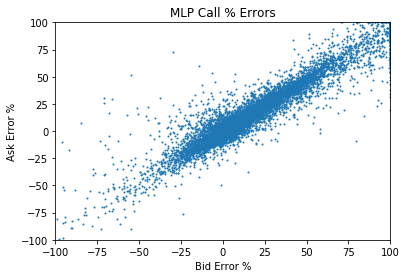

In [189]:
loss_plot(cally_test,call250_y_predictions)

In [115]:
call_x_test

,TTE,strike_price,treasury_rate,sec_price,vol_20
73791,380,36.0,0.30,35.930,0.016490
1590816,220,42.0,0.41,16.160,0.043622
2250210,361,25.0,1.79,26.250,0.019597
524236,303,65.0,0.14,21.020,0.044703
1058823,80,33.0,0.03,31.019,0.063393
...,...,...,...,...,...
2995835,11,54.0,2.04,24.480,0.057684
2026072,506,64.0,1.23,47.650,0.678849
2946485,148,18.0,2.08,22.200,0.022500
1233758,31,25.5,0.01,21.470,0.026204


In [552]:
call_x_test

,TTE,strike_price,treasury_rate,sec_price,vol_20,black_scholes_pred
73791,380,36.0,0.30,35.930,0.016490,35.894112
1590816,220,42.0,0.41,16.160,0.043622,16.118104
2250210,361,25.0,1.79,26.250,0.019597,26.225439
524236,303,65.0,0.14,21.020,0.044703,20.955075
1058823,80,33.0,0.03,31.019,0.063393,30.986002
...,...,...,...,...,...,...
2995835,11,54.0,2.04,24.480,0.057684,24.426033
2026072,506,64.0,1.23,47.650,0.678849,47.587082
2946485,148,18.0,2.08,22.200,0.022500,22.182151
1233758,31,25.5,0.01,21.470,0.026204,21.444500


In [559]:
#black scholes formula for call options
def black_scholes(row):
    S = row.sec_price
    X = row.strike_price 
    T = row.TTE / 365
    r = row.treasury_rate / 100
    σ = row.vol_20
    d1 = (np.log(S / X) + (r + (σ ** 2) / 2) * T) / (σ * (T ** .5))
    d2 = d1 - σ * (T ** .5)
    C = S * norm.cdf(d1) - X * np.exp(-r * T) * norm.cdf(d2)
    return C

In [560]:
call_x_test['black_scholes_pred'] = call_x_test.apply(lambda row: black_scholes(row), axis=1)
call_x_test

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  


In [564]:
call_x_train['black_scholes_pred'] = call_x_train.apply(lambda row: black_scholes(row), axis=1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


In [561]:
bs_test_set = call_x_test.merge(call_y_test,left_index=True, right_index=True)
bs_test_set

,TTE,strike_price,treasury_rate,sec_price,vol_20,black_scholes_pred,best_bid,best_offer
73791,380,36.0,0.30,35.930,0.016490,2.627483e-01,0.00,0.44
1590816,220,42.0,0.41,16.160,0.043622,6.641110e-176,0.77,0.81
2250210,361,25.0,1.79,26.250,0.019597,1.688742e+00,0.22,0.48
524236,303,65.0,0.14,21.020,0.044703,2.612114e-170,0.00,0.02
1058823,80,33.0,0.03,31.019,0.063393,6.422807e-03,3.30,3.45
...,...,...,...,...,...,...,...,...
2995835,11,54.0,2.04,24.480,0.057684,0.000000e+00,0.00,0.01
2026072,506,64.0,1.23,47.650,0.678849,1.050265e+01,11.65,12.55
2946485,148,18.0,2.08,22.200,0.022500,4.351173e+00,5.60,5.75
1233758,31,25.5,0.01,21.470,0.026204,9.469688e-115,0.50,0.54


In [565]:
bs_train_set = call_x_train.merge(call_y_train,left_index=True, right_index=True)
bs_train_set

,TTE,strike_price,treasury_rate,sec_price,vol_20,black_scholes_pred,best_bid,best_offer
282029,85,48.0,0.06,26.07,0.019863,0.000000e+00,0.44,0.47
1709761,165,27.0,0.48,33.89,0.060087,6.948523e+00,9.55,9.70
2166550,45,30.0,1.06,35.16,0.019018,5.199180e+00,5.70,6.00
880356,241,20.0,0.06,35.22,0.011536,1.522792e+01,14.40,15.75
354676,200,41.0,0.14,21.17,0.047798,2.910042e-79,1.86,1.94
...,...,...,...,...,...,...,...,...
1454413,14,19.5,0.20,24.83,0.059223,5.331496e+00,5.35,5.50
2775140,39,50.0,2.42,39.46,0.038466,3.161027e-79,0.70,0.85
1591649,93,25.0,0.26,16.00,0.043691,9.416858e-93,1.09,1.12
1304326,38,24.0,0.05,15.83,0.036534,2.055275e-275,0.21,0.24


In [562]:
mse = lambda df, pred_col: np.sum(np.square(df[['best_bid', 'best_offer']].mean(axis=1) - df[pred_col])) / df.shape[0]

In [563]:
mse(bs_test_set, 'black_scholes_pred')

36.65029276883788

In [566]:
mse(bs_train_set, 'black_scholes_pred')

37.93392844105544

In [162]:
sum(history350['loss'][::-1][0:5])/5

5.329579639434814

In [178]:
sum(history350['val_loss'][245:250])/5

5.804492378234864

In [404]:
def error_metrics(actual, predicted):
    diff = actual - predicted
    mse = np.mean(np.square(diff))
    rel = diff / actual
    bias = np.median(rel)
    aape = 100 * np.mean(np.abs(rel))
    mape = 100 * np.median(np.abs(rel))
    pe5 = 100 * sum(np.abs(rel) < 0.05) / rel.shape[0]
    pe10 = 100 * sum(np.abs(rel) < 0.10) / rel.shape[0]
    pe20 = 100 * sum(np.abs(rel) < 0.20) / rel.shape[0]
    return diff, [mse, bias, aape, mape, pe5, pe10, pe20]

In [684]:
diff, call_errors = error_metrics(np.mean(cally_test, axis=1), np.mean(call250_y_predictions, axis=1))

In [685]:
call_errors
print('MSE: ', call_errors[0])
print('Bias: ', call_errors[1])
print('AAPE: ', call_errors[2])
print('MAPE: ', call_errors[3])
print('PE5: ', call_errors[4])
print('PE10: ', call_errors[5])
print('PE20: ', call_errors[6])

MSE:  5.142074162905888
Bias:  16.984227624270005
AAPE:  863.2361296016676
MAPE:  29.577389967094348
PE5:  16.61646908042294
PE10:  28.599807753925024
PE20:  42.37103492470362


In [686]:
rel = diff  / np.mean(cally_test, axis=1)
np.mean(rel)

-7.8687976735522405

In [687]:
rel = diff / np.mean(cally_test, axis=1)
print(np.quantile(rel, [0.25,0.75]))
rel_fixed = rel[rel.between(-0.21047592,1,inclusive=False)]

bias = np.median(rel_fixed)
aape = 100 * np.mean(np.abs(rel_fixed))
mape = 100 * np.median(np.abs(rel_fixed))
pe5 = 100 * sum(np.abs(rel_fixed) < 0.05) / rel_fixed.shape[0]
pe10 = 100 * sum(np.abs(rel_fixed) < 0.10) / rel_fixed.shape[0]
pe20 = 100 * sum(np.abs(rel_fixed) < 0.20) / rel_fixed.shape[0]


print('Bias: ', bias)
print('AAPE: ', aape)
print('MAPE: ', mape)
print('PE5: ', pe5)
print('PE10: ', pe10)
print('PE20: ', pe20)

[0.00238297 1.        ]
Bias:  0.09838364439702485
AAPE:  20.313005639921357
MAPE:  11.770765981771339
PE5:  26.03413654618474
PE10:  44.80923694779116
PE20:  66.3855421686747


In [647]:
np.mean(rel_fixed)

0.17311596052425676

Text(0.5, 1.0, 'MLP Call Distribution of % Errors (Full)')

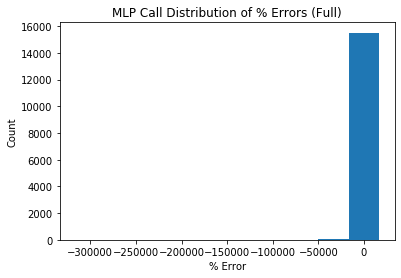

In [651]:
rel = diff / np.mean(cally_test, axis=1)
mpl.pyplot.hist(rel*100,align='right')
plt.ylabel("Count")
plt.xlabel("% Error")
plt.title("MLP Call Distribution of % Errors (Full)")

Text(0.5, 1.0, 'MLP Call Distribution of % Errors (1st to 9th Decile)')

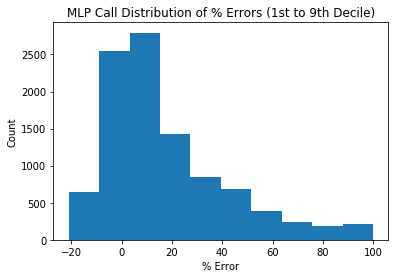

In [650]:
mpl.pyplot.hist(rel_fixed*100, align = 'mid')
plt.ylabel("Count")
plt.xlabel("% Error")
plt.title("MLP Call Distribution of % Errors (1st to 9th Decile)")

23.898009586334226


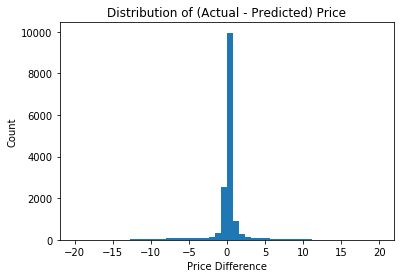

In [450]:
mpl.pyplot.hist(diff,bins = 50,range = [-20,20])
plt.title("MLP Call Distribution of (Actual - Predicted) Price")
plt.ylabel("Count")
plt.xlabel("Price Difference")
print(max(diff))

In [330]:
q = np.linspace(0,1,33)
rel.quantile(q=q)

0.00000   -3335.570358
0.03125     -27.561854
0.06250      -4.150869
0.09375      -0.244702
0.12500      -0.119621
0.15625      -0.069048
0.18750      -0.038373
0.21875      -0.015759
0.25000       0.002383
0.28125       0.019072
0.31250       0.036644
0.34375       0.052064
0.37500       0.069042
0.40625       0.089564
0.43750       0.111694
0.46875       0.140289
0.50000       0.169842
0.53125       0.207268
0.56250       0.256394
0.59375       0.308412
0.62500       0.385967
0.65625       0.460475
0.68750       0.583234
0.71875       0.816938
0.75000       1.000000
0.78125       1.000000
0.81250       1.000000
0.84375       1.000000
0.87500       1.000000
0.90625       1.000000
0.93750       1.000000
0.96875       1.000000
1.00000       1.000000
dtype: float64

In [568]:
bs_preds = bs_test_set['black_scholes_pred'].reset_index(drop = True)
bs_preds

0         2.627483e-01
1        6.641110e-176
2         1.688742e+00
3        2.612114e-170
4         6.422807e-03
             ...      
15600     0.000000e+00
15601     1.050265e+01
15602     4.351173e+00
15603    9.469688e-115
15604     1.698523e-96
Name: black_scholes_pred, Length: 15605, dtype: float64

In [569]:
np.mean(cally_test, axis=1)

0         0.220
1         0.790
2         0.350
3         0.010
4         3.375
          ...  
15600     0.005
15601    12.100
15602     5.675
15603     0.520
15604     0.130
Length: 15605, dtype: float64

In [570]:
bs_call_errors = error_metrics(np.mean(cally_test, axis=1), bs_preds)
bs_call_errors

(0       -0.042748
 1        0.790000
 2       -1.338742
 3        0.010000
 4        3.368577
            ...   
 15600    0.005000
 15601    1.597351
 15602    1.323827
 15603    0.520000
 15604    0.130000
 Length: 15605, dtype: float64,
 [36.65029276883797,
  1.0,
  2517.928756443707,
  100.0,
  16.18711951297661,
  18.852931752643382,
  21.800704902274912])

In [575]:
bs_diff = np.mean(cally_test, axis=1) - bs_preds
bs_rel = bs_diff / np.mean(cally_test, axis=1)
bs_rel = bs_rel.replace([np.inf, -np.inf], np.nan)
bs_rel = bs_rel.dropna()

bias = np.median(bs_rel)
aape = 100 * np.mean(np.abs(bs_rel))
mape = 100 * np.median(np.abs(bs_rel))
pe5 = 100 * sum(np.abs(bs_rel) < 0.05) / bs_rel.shape[0]
pe10 = 100 * sum(np.abs(bs_rel) < 0.10) / bs_rel.shape[0]
pe20 = 100 * sum(np.abs(bs_rel) < 0.20) / bs_rel.shape[0]


print('Bias: ', bias)
print('AAPE: ', aape)
print('MAPE: ', mape)
print('PE5: ', pe5)
print('PE10: ', pe10)
print('PE20: ', pe20)

Bias:  1.0
AAPE:  2517.928756443707
MAPE:  100.0
PE5:  16.18711951297661
PE10:  18.852931752643382
PE20:  21.800704902274912


In [574]:
bs_rel

0       -0.194311
1        1.000000
2       -3.824977
3        1.000000
4        0.998097
           ...   
15600    1.000000
15601    0.132013
15602    0.233273
15603    1.000000
15604    1.000000
Length: 15605, dtype: float64

Text(0.5, 1.0, 'BS Distribution of % Errors')

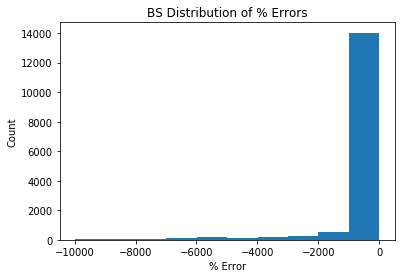

In [515]:
mpl.pyplot.hist(bs_rel, align = 'mid')
plt.ylabel("Count")
plt.xlabel("% Error")
plt.title("BS Distribution of % Errors")

# Put Options

In [522]:
# fit the model
put_history = mod.fit(put_x_train, put_y_train, 
                    batch_size = 1024, epochs = 250, 
                    validation_split = 0.01,
                    callbacks=[TensorBoard(histogram_freq = 10, update_freq = 'epoch', write_graph = True)],
                    verbose=1)

Epoch 1/250
1494/1494 [==============================] - 30s 20ms/step - loss: 22.3927 - val_loss: 23.0482
Epoch 2/250
1494/1494 [==============================] - 30s 20ms/step - loss: 17.3174 - val_loss: 19.8362
Epoch 3/250
1494/1494 [==============================] - 31s 21ms/step - loss: 16.5051 - val_loss: 17.6703
Epoch 4/250
1494/1494 [==============================] - 33s 22ms/step - loss: 15.7667 - val_loss: 22.8941
Epoch 5/250
1494/1494 [==============================] - 33s 22ms/step - loss: 15.3784 - val_loss: 14.8536
Epoch 6/250
1494/1494 [==============================] - 33s 22ms/step - loss: 15.0979 - val_loss: 16.0122
Epoch 7/250
1494/1494 [==============================] - 33s 22ms/step - loss: 14.9218 - val_loss: 15.7166
Epoch 8/250
1494/1494 [==============================] - 34s 23ms/step - loss: 14.7747 - val_loss: 14.2826
Epoch 9/250
1494/1494 [==============================] - 34s 23ms/step - loss: 14.6443 - val_loss: 14.5884
Epoch 10/250
1494/1494 [=============

In [523]:
#save the model and history
mod.save('mod_put_250e')
mod_put_250e_history = put_history.history
np.save('250e_put_history.npy', mod_put_250e_history)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: mod_put_250e/assets


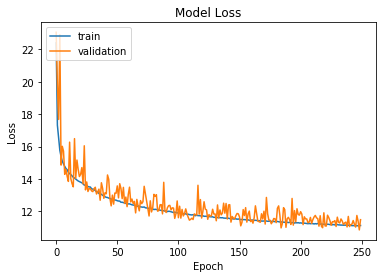

In [524]:
# Plot of model loss across train and test(validation) sets by epoch
plt.plot(mod_put_250e_history['loss'])
plt.plot(mod_put_250e_history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [525]:
putresults = mod.evaluate(put_x_test,put_y_test)
print(putresults)

488/488 [==============================] - 0s 624us/step - loss: 10.8594
10.859350204467773


In [526]:
put_y_predictions = mod.predict(put_x_test)
put_y_predictions = pd.DataFrame(put_y_predictions)

#model's predicted bid and ask prices
put_y_predictions = put_y_predictions.rename(columns={0:"best_bid",1:"best_offer"})
put_y_predictions

,best_bid,best_offer
0,41.556957,42.663124
1,0.000000,0.000000
2,1.696333,1.835639
3,33.075184,34.347500
4,8.899878,9.169362
...,...,...
15599,70.514259,71.378830
15600,10.390059,11.577416
15601,16.993336,17.600636
15602,2.115471,2.131611


In [528]:
put_y_test = put_y_test.reset_index()
put_y_test = put_y_test[['best_bid', 'best_offer']]
put_y_test

,best_bid,best_offer
0,41.80,41.90
1,0.00,0.01
2,1.95,1.97
3,32.50,36.50
4,8.90,9.05
...,...,...
15599,71.85,72.10
15600,12.20,14.20
15601,17.05,17.45
15602,1.98,2.02


In [530]:
# create a plot of test set % error. Plot ask % error against ask % error.
def loss_plot(test, prediction):
    temp = 100 * (test - prediction) / test
    plt.scatter(temp.iloc[:,0], temp.iloc[:,1], s=1)
    plt.xlim(-100, 100)
    plt.ylim(-100, 100)
    plt.xlabel('Bid Error %')
    plt.ylabel('Ask Error %')
    plt.title("MLP Put % Errors")
    print(temp)

        best_bid  best_offer
0       0.581442   -1.821299
1            NaN  100.000000
2      13.008555    6.820355
3      -1.769797    5.897261
4       0.001376   -1.318918
...          ...         ...
15599   1.859068    1.000236
15600  14.835586   18.468898
15601   0.332342   -0.863241
15602  -6.841976   -5.525314
15603  17.606701   12.548308

[15604 rows x 2 columns]


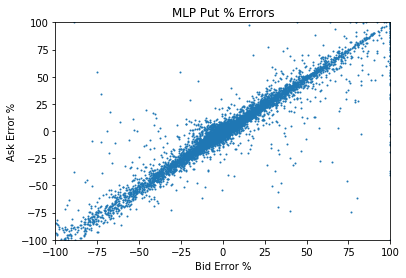

In [531]:
loss_plot(put_y_test, put_y_predictions)

In [543]:
def black_scholes_put(row):
    S = row.sec_price
    X = row.strike_price
    T = row.TTE / 365
    r = row.treasury_rate
    σ = row.vol_20
    d1 = (np.log(S / X) + (r + (σ ** 2) / 2) * T) / (σ * (T ** .5))
    d2 = d1 - σ * (T ** .5)
    P  = norm.cdf(-d2) * X * np.exp(-r * T) - S * norm.cdf(-d1)
    return P

In [544]:
put_x_test['black_scholes_pred'] = put_x_test.apply(lambda row: black_scholes_put(row), axis=1)
put_x_train['black_scholes_pred'] = put_x_train.apply(lambda row: black_scholes_put(row), axis=1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


In [547]:
put_x_train['black_scholes_pred']

2187440    1.277558e-106
1372446     1.156987e-65
1074042     0.000000e+00
796916      5.236314e+00
2665319     0.000000e+00
               ...      
1454585     1.861096e+00
2775350     4.712304e+00
1591805     0.000000e+00
1304420     1.065528e+00
1787502     1.768848e+01
Name: black_scholes_pred, Length: 1544743, dtype: float64

In [548]:
put_y_test

,best_bid,best_offer
0,41.80,41.90
1,0.00,0.01
2,1.95,1.97
3,32.50,36.50
4,8.90,9.05
...,...,...
15599,71.85,72.10
15600,12.20,14.20
15601,17.05,17.45
15602,1.98,2.02


In [546]:
put_x_test

,TTE,strike_price,treasury_rate,sec_price,vol_20,black_scholes_pred
403975,116,51.0,0.11,9.245,0.040892,4.000290e+01
2576287,7,19.0,2.21,33.310,0.042391,0.000000e+00
784042,52,40.0,0.05,43.200,0.043843,2.365023e-08
2774202,49,74.0,2.43,39.310,0.039496,1.409188e+01
1402411,8,29.5,0.08,20.560,0.045292,8.888319e+00
...,...,...,...,...,...,...
1270002,210,90.0,0.05,18.230,0.023705,6.921784e+01
53284,415,23.0,0.29,43.310,0.675801,7.773217e-01
350288,211,35.0,0.14,20.210,0.040344,1.206899e+01
1918484,29,16.5,0.70,15.010,0.034353,5.973819e-01


In [549]:
bs_put_test_set = put_x_test.merge(put_y_test,left_index=True, right_index=True)
bs_put_test_set

,TTE,strike_price,treasury_rate,sec_price,vol_20,black_scholes_pred,best_bid,best_offer
974,198,20.0,0.22,28.40,0.067566,2.064290e-22,21.40,21.50
12490,176,23.0,0.20,22.57,0.030169,1.166333e-05,14.95,15.05
7855,68,37.0,0.16,25.24,0.038315,1.067337e+01,12.75,12.90
4363,179,25.0,0.18,26.49,0.042923,8.189237e-08,19.25,21.25
1907,38,43.0,0.08,31.18,0.054766,1.146335e+01,2.60,2.61
...,...,...,...,...,...,...,...,...
12888,229,13.0,0.20,21.23,0.031189,2.540596e-139,0.00,0.02
1381,40,45.0,0.10,32.27,0.056225,1.223954e+01,6.20,6.50
12896,229,21.0,0.20,21.23,0.031189,1.417332e-09,0.22,0.23
12895,229,20.0,0.20,21.23,0.031189,2.043206e-15,0.00,0.01


In [550]:
mse = lambda df, pred_col: np.sum(np.square(df[['best_bid', 'best_offer']].mean(axis=1) - df[pred_col])) / df.shape[0]

In [551]:
mse(bs_put_test_set, 'black_scholes_pred')

384.3145433803998

In [579]:
def error_metrics(actual, predicted):
    diff = actual - predicted
    mse = np.mean(np.square(diff))
    rel = diff / actual
    bias = 100 * np.median(rel)
    aape = 100 * np.mean(np.abs(rel))
    mape = 100 * np.median(np.abs(rel))
    pe5 = 100 * sum(np.abs(rel) < 0.05) / rel.shape[0]
    pe10 = 100 * sum(np.abs(rel) < 0.10) / rel.shape[0]
    pe20 = 100 * sum(np.abs(rel) < 0.20) / rel.shape[0]
    return diff, [mse, bias, aape, mape, pe5, pe10, pe20]

In [688]:
diff, put_errors = error_metrics(np.mean(put_y_test, axis=1), np.mean(put_y_predictions, axis=1))

In [689]:
put_errors
print('MSE: ', put_errors[0])
print('Bias: ', put_errors[1])
print('AAPE: ', put_errors[2])
print('MAPE: ', put_errors[3])
print('PE5: ', put_errors[4])
print('PE10: ', put_errors[5])
print('PE20: ', put_errors[6])

MSE:  10.774003951928217
Bias:  0.6878337469568375
AAPE:  1055.3234673071631
MAPE:  8.614021786800622
PE5:  42.12381440656242
PE10:  51.83927198154319
PE20:  60.71520123045373


In [690]:
rel_put = diff / np.mean(put_y_test, axis=1)
np.quantile(rel_put, [0.25,0.75])

array([-0.07447008,  0.10315244])

In [617]:
rel_put = diff / np.mean(put_y_test, axis=1)
rel_fixed = rel_put[rel_put.between(-0.97124449,1,inclusive = False)]

mse = np.mean(np.square(diff))
bias = 100* np.median(rel_fixed)
aape = 100 * np.mean(np.abs(rel_fixed))
mape = 100 * np.median(np.abs(rel_fixed))
pe5 = 100 * sum(np.abs(rel_fixed) < 0.05) / rel_fixed.shape[0]
pe10 = 100 * sum(np.abs(rel_fixed) < 0.10) / rel_fixed.shape[0]
pe20 = 100 * sum(np.abs(rel_fixed) < 0.20) / rel_fixed.shape[0]

print("MSE: ", mse)
print('Bias: ', bias)
print('AAPE: ', aape)
print('MAPE: ', mape)
print('PE5: ', pe5)
print('PE10: ', pe10)
print('PE20: ', pe20)

MSE:  10.774003951928217
Bias:  0.5868353126545972
AAPE:  13.724418670517135
MAPE:  4.220647397248642
PE5:  53.652763039751854
PE10:  66.02726308056485
PE20:  77.33246265610971


In [594]:
bs_put_preds = bs_put_test_set['black_scholes_pred'].reset_index(drop = True)
bs_put_preds

0      2.064290e-22
1      1.166333e-05
2      1.067337e+01
3      8.189237e-08
4      1.146335e+01
          ...      
78    2.540596e-139
79     1.223954e+01
80     1.417332e-09
81     2.043206e-15
82     4.249639e-89
Name: black_scholes_pred, Length: 83, dtype: float64

In [596]:
bs_diff = np.mean(put_y_test, axis=1) - bs_put_preds
bs_rel = bs_diff / np.mean(cally_test, axis=1)
bs_rel = bs_rel.replace([np.inf, -np.inf], np.nan)
bs_rel = bs_rel.dropna()

bias = 100* np.median(bs_rel)
aape = 100 * np.mean(np.abs(bs_rel))
mape = 100 * np.median(np.abs(bs_rel))
pe5 = 100 * sum(np.abs(bs_rel) < 0.05) / bs_rel.shape[0]
pe10 = 100 * sum(np.abs(bs_rel) < 0.10) / bs_rel.shape[0]
pe20 = 100 * sum(np.abs(bs_rel) < 0.20) / bs_rel.shape[0]


print('Bias: ', bias)
print('AAPE: ', aape)
print('MAPE: ', mape)
print('PE5: ', pe5)
print('PE10: ', pe10)
print('PE20: ', pe20)

Bias:  193.4242504475471
AAPE:  29202.971861380614
MAPE:  427.1844660194172
PE5:  3.6144578313253013
PE10:  4.819277108433735
PE20:  7.228915662650603


In [598]:
min(bs_diff)

-21.69225387135056

In [607]:
np.max(rel_put)

1.0

In [618]:
np.max(rel_fixed)

0.9974341097614527

In [619]:
rel_fixed

0       -0.006214
2        0.098987
3        0.022860
4       -0.006643
6        0.001845
           ...   
15599    0.014289
15600    0.167899
15601   -0.002724
15602   -0.061771
15603    0.150009
Length: 12251, dtype: float64

In [620]:
rel_put

0       -0.006214
1        1.000000
2        0.098987
3        0.022860
4       -0.006643
           ...   
15599    0.014289
15600    0.167899
15601   -0.002724
15602   -0.061771
15603    0.150009
Length: 15604, dtype: float64

In [626]:
np.mean(rel_put)

-10.209206700434196

In [632]:
np.max(rel_fixed)

0.9974341097614527

Text(0.5, 1.0, 'MLP Put Distribution of % Errors (Full)')

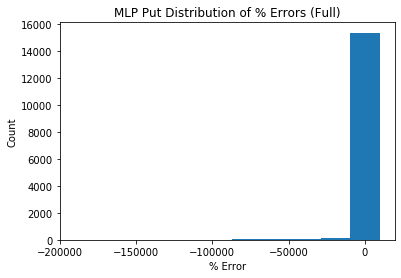

In [703]:
rel_put = diff / np.mean(put_y_test, axis=1)
rel_fixed = rel_put[rel_put.between(-0.97124449,1,inclusive = False)]
mpl.pyplot.hist(rel_put*100,align='right')
plt.ylabel("Count")
plt.xticks([-200000,-150000,-100000,-50000,0])
plt.xlabel("% Error")
plt.title("MLP Put Distribution of % Errors (Full)")

In [697]:
np.min(rel_put)

-1933.556198120117

Text(0.5, 1.0, 'MLP Put Distribution of % Errors (1st to 9th Decile)')

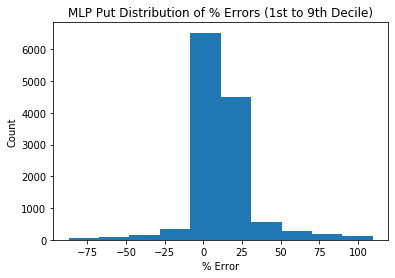

In [655]:
mpl.pyplot.hist(rel_fixed*100,align='right')
plt.ylabel("Count")
plt.xlabel("% Error")
plt.title("MLP Put Distribution of % Errors (1st to 9th Decile)")